Fitting 5 folds for each of 32 candidates, totalling 160 fits

✅ Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 1}

🎯 Test Accuracy: 0.8333
🏥 ROC-AUC Score: 0.8597

📄 Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.83      0.85        30
           1       0.80      0.83      0.82        24

    accuracy                           0.83        54
   macro avg       0.83      0.83      0.83        54
weighted avg       0.83      0.83      0.83        54

🧾 Confusion Matrix:
 [[25  5]
 [ 4 20]]


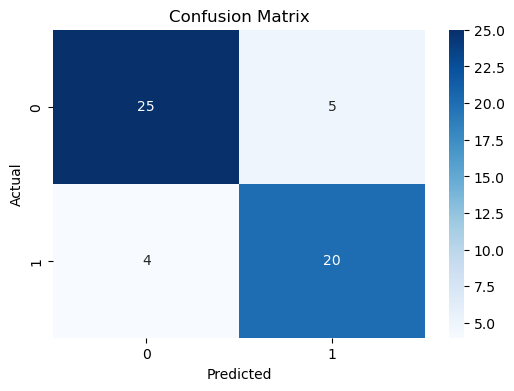

In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

# 1. Load Data
df = pd.read_csv("heart_disease_prediction.csv")
df.columns = [c.strip().replace(" ", "_") for c in df.columns]
target_column = 'Heart_Disease' if 'Heart_Disease' in df.columns else 'target'

# 2. Encode categorical features
categorical_cols = df.select_dtypes(include='object').columns.tolist()
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# 3. Features and Target
X = df.drop(target_column, axis=1)
y = df[target_column]

# 4. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 5. Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 6. SMOTE on training data only
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

# 7. XGBoost with hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1],
    'reg_alpha': [0, 0.5],
    'reg_lambda': [1, 2]
}

xgb = XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(xgb, param_grid, cv=cv, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train_res, y_train_res)

best_model = grid_search.best_estimator_

# 8. Predict and evaluate
y_pred = best_model.predict(X_test_scaled)
y_proba = best_model.predict_proba(X_test_scaled)[:, 1]

print(f"\n✅ Best Parameters: {grid_search.best_params_}")
print(f"\n🎯 Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"🏥 ROC-AUC Score: {roc_auc_score(y_test, y_proba):.4f}")
print("\n📄 Classification Report:\n", classification_report(y_test, y_pred))
print("🧾 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# 9. Save model and scaler
joblib.dump(best_model, "heart_model_xgb.pkl")
joblib.dump(scaler, "scaler.pkl")

# 10. Optional: plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [15]:
import tkinter as tk
from tkinter import ttk, messagebox
import numpy as np
import joblib
import shap
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

# Load trained model and scaler
model = joblib.load("heart_model_xgb.pkl")
scaler = joblib.load("scaler.pkl")

# Feature names and types
numeric_features = [
    ("Age", "years"),
    ("RestingBP", "mm Hg"),
    ("Cholesterol", "mg/dL"),
    ("MaxHR", "bpm"),
    ("Oldpeak", "ST depression"),
    ("MajorVessels", "number")
]

categorical_features = {
    "Sex": ["Female", "Male"],
    "ChestPainType": ["Asymptomatic", "Atypical Angina", "Non-Anginal", "Typical Angina"],
    "FastingBS": ["No", "Yes"],
    "RestingECG": ["Normal", "ST-T Abnormality", "LV Hypertrophy"],
    "ExerciseAngina": ["No", "Yes"],
    "ST_Slope": ["Downsloping", "Flat", "Upsloping"],
    "Thal": ["Fixed Defect", "Normal", "Reversible Defect"]
}

# Mapping for encoding
label_encodings = {key: {v: i for i, v in enumerate(vals)} for key, vals in categorical_features.items()}

# GUI Setup
root = tk.Tk()
root.title("Heart Disease Prediction")
root.geometry("500x750")
root.configure(bg="#f0f0f0")

tk.Label(root, text="Heart Disease Risk Predictor", font=("Arial", 18, "bold"), bg="#f0f0f0", fg="#333").pack(pady=10)

frame = tk.Frame(root, bg="#f0f0f0")
frame.pack()

# Input widgets
inputs = {}

for name, unit in numeric_features:
    tk.Label(frame, text=f"{name} ({unit})", bg="#f0f0f0").pack(anchor='w', padx=20, pady=(5, 0))
    entry = tk.Entry(frame, width=25)
    entry.pack(padx=20)
    inputs[name] = entry

for cat_feat, options in categorical_features.items():
    tk.Label(frame, text=f"{cat_feat} ({' / '.join(options)})", bg="#f0f0f0").pack(anchor='w', padx=20, pady=(8, 0))
    dropdown = ttk.Combobox(frame, values=options, state="readonly", width=23)
    dropdown.pack(padx=20)
    dropdown.current(0)
    inputs[cat_feat] = dropdown

def predict():
    try:
        # Get inputs
        vals = []
        for name, _ in numeric_features:
            val = float(inputs[name].get())
            vals.append(val)
        for name in categorical_features.keys():
            label = inputs[name].get()
            val = label_encodings[name][label]
            vals.append(val)

        input_array = np.array([vals])
        scaled_input = scaler.transform(input_array)

        # Prediction
        prob = model.predict_proba(scaled_input)[0][1]
        pred = model.predict(scaled_input)[0]
        status = "Risky" if prob >= 0.5 else "Healthy"

        messagebox.showinfo("Prediction", f"🩺 Status: {status}\n🔢 Probability: {prob:.2f}")

        # SHAP explanation
        explainer = shap.Explainer(model, scaler.transform)
        shap_vals = explainer(input_array)

        plt.figure()
        shap.plots.waterfall(shap_vals[0], show=False)
        fig = plt.gcf()

        # Display in a new window
        shap_win = tk.Toplevel(root)
        shap_win.title("SHAP Explanation")
        canvas = FigureCanvasTkAgg(fig, master=shap_win)
        canvas.draw()
        canvas.get_tk_widget().pack()
        plt.close()

    except Exception as e:
        messagebox.showerror("Input Error", str(e))

tk.Button(root, text="Predict Risk", font=("Arial", 12), bg="#007acc", fg="white",
          command=predict).pack(pady=20)

tk.Label(root, text="Note:\nCategorical values are encoded internally for the model.",
         font=("Arial", 9), bg="#f0f0f0", fg="#777").pack(pady=(5, 15))

root.mainloop()


In [ ]:
# Sample input — Healthy profile
sample = [[45, 1, 2, 128, 200, 0, 0, 160, 0, 0.5, 1, 0, 2]]

# Load saved model and scaler
model = joblib.load("heart_model_xgb.pkl")
scaler = joblib.load("scaler.pkl")

scaled_input = scaler.transform(sample)
prob = model.predict_proba(scaled_input)[0][1]
prediction = model.predict(scaled_input)[0]
status = "Unhealthy" if prob >= 0.5 else "Healthy"

#print(f"🧪 Predicted Probability: {prob:.2f}")
print(f"🩺 Risk Category: {status}")


🩺 Risk Category: Healthy


In [13]:
# 🚨 High-risk profile (values aligned to feature order)
risky_sample = [[65, 1, 3, 150, 280, 1, 2, 110, 1, 2.3, 2, 2, 2]]

# Load model and scaler
import joblib
model = joblib.load("heart_model_xgb.pkl")
scaler = joblib.load("scaler.pkl")

# Scale and predict
scaled_input = scaler.transform(risky_sample)
prob = model.predict_proba(scaled_input)[0][1]
prediction = model.predict(scaled_input)[0]
status = "Unhealthy" if prob >= 0.5 else "Healthy"

# Output
#print(f"🧪 Predicted Probability: {prob:.2f}")
print(f"🩺 Risk Category: {status}")


🩺 Risk Category: Unhealthy


In [ ]:
# import tkinter as tk
# from tkinter import messagebox
# import numpy as np
# import joblib
# import shap
# import matplotlib.pyplot as plt
# from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

# # Load model and scaler
# model = joblib.load("heart_model_xgb.pkl")
# scaler = joblib.load("scaler.pkl")

# # Feature labels
# feature_names = ['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol',
#                  'FastingBS', 'RestingECG', 'MaxHR', 'ExerciseAngina',
#                  'Oldpeak', 'ST_Slope', 'MajorVessels', 'Thal']

# # GUI
# root = tk.Tk()
# root.title("Heart Disease Prediction with SHAP")

# entries = []
# for i, label in enumerate(feature_names):
#     tk.Label(root, text=label).grid(row=i, column=0)
#     entry = tk.Entry(root)
#     entry.grid(row=i, column=1)
#     entries.append(entry)

# def predict():
#     try:
#         vals = [float(e.get()) for e in entries]
#         input_data = np.array([vals])
#         scaled = scaler.transform(input_data)
#         prob = model.predict_proba(scaled)[0][1]
#         pred = model.predict(scaled)[0]
#         status = "Risky" if prob >= 0.5 else "Healthy"
#         messagebox.showinfo("Prediction Result", f"Risk Category: {status}\nProbability: {prob:.2f}")

#         # SHAP Explanation
#         explainer = shap.Explainer(model, scaler.transform)
#         shap_vals = explainer(input_data)

#         # Plot waterfall
#         plt.figure()
#         shap.plots.waterfall(shap_vals[0], show=False)
#         canvas_frame = tk.Toplevel(root)
#         canvas_frame.title("SHAP Explanation")

#         fig = plt.gcf()
#         canvas = FigureCanvasTkAgg(fig, master=canvas_frame)
#         canvas.draw()
#         canvas.get_tk_widget().pack()
#         plt.close()

#     except Exception as e:
#         messagebox.showerror("Error", str(e))

# tk.Button(root, text="Predict Risk", command=predict).grid(row=len(feature_names), column=0, columnspan=2)

# root.mainloop()


In [ ]:
import tkinter as tk
from tkinter import ttk, messagebox
import numpy as np
import joblib

# Load model and scaler
model = joblib.load("heart_model_xgb.pkl")
scaler = joblib.load("scaler.pkl")

# Label mappings for categorical features
mappings = {
    "Sex": {0: "Female", 1: "Male"},
    "ChestPainType": {0: "Typical Angina", 1: "Atypical Angina", 2: "Non-anginal Pain", 3: "Asymptomatic"},
    "RestingECG": {0: "Normal", 1: "ST-T wave abnormality", 2: "Left ventricular hypertrophy"},
    "ExerciseAngina": {0: "No", 1: "Yes"},
    "ST_Slope": {0: "Up", 1: "Flat", 2: "Down"},
    "Thalassemia": {0: "Normal", 1: "Fixed Defect", 2: "Reversible Defect"}
}

# Reverse mappings
reverse_mappings = {feat: {v: k for k, v in d.items()} for feat, d in mappings.items()}

# Define features: (name, type)
features = [
    ("Age", "numeric"),
    ("Sex", "categorical"),
    ("ChestPainType", "categorical"),
    ("RestingBP", "numeric"),
    ("Cholesterol", "numeric"),
    ("FastingBS", "numeric"),
    ("RestingECG", "categorical"),
    ("MaxHR", "numeric"),
    ("ExerciseAngina", "categorical"),
    ("Oldpeak", "numeric"),
    ("ST_Slope", "categorical"),
    ("NumMajorVessels", "numeric"),
    ("Thalassemia", "categorical")
]

# Build GUI
root = tk.Tk()
root.title("Heart Disease Risk Predictor")
root.geometry("620x750")
root.configure(bg="white")

tk.Label(root, text="💓 Heart Disease Risk Predictor", font=("Arial", 20, "bold"), bg="white", fg="darkred").pack(pady=10)

form_frame = tk.Frame(root, bg="white")
form_frame.pack(pady=10)

entries = {}
dropdowns = {}

for idx, (feature, ftype) in enumerate(features):
    tk.Label(form_frame, text=feature, font=("Arial", 12), anchor="w", width=20, bg="white").grid(row=idx, column=0, pady=6, sticky="w")

    if ftype == "categorical":
        combo = ttk.Combobox(form_frame, values=list(mappings[feature].values()), state="readonly", width=30)
        combo.grid(row=idx, column=1, padx=10)
        dropdowns[feature] = combo
    else:
        entry = tk.Entry(form_frame, width=33)
        entry.grid(row=idx, column=1, padx=10)
        entries[feature] = entry

# Prediction logic
def predict():
    try:
        input_data = []
        for feature, ftype in features:
            if ftype == "categorical":
                value = dropdowns[feature].get()
                if value == "":
                    raise ValueError(f"Select a value for {feature}")
                input_data.append(reverse_mappings[feature][value])
            else:
                val = entries[feature].get()
                if val.strip() == "":
                    raise ValueError(f"Enter a value for {feature}")
                input_data.append(float(val))

        arr = np.array(input_data).reshape(1, -1)
        arr_scaled = scaler.transform(arr)
        prediction = model.predict(arr_scaled)[0]
        probability = model.predict_proba(arr_scaled)[0][1]

        result = "💔 At Risk" if prediction == 1 else "✅ Healthy"
        messagebox.showinfo("Prediction Result", f"Prediction: {result}")

    except Exception as e:
        messagebox.showerror("Input Error", str(e))

tk.Button(root, text="Predict", font=("Arial", 14), bg="darkred", fg="white", width=20, command=predict).pack(pady=20)

# Footer/Disclaimer
tk.Label(root, text="Disclaimer: This is a prediction tool only.\nConsult a doctor for accurate diagnosis.",
         font=("Arial", 10), fg="gray", bg="white").pack(pady=10)

root.mainloop()
